# Time Series Analysis of Solar Data

### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

### Import data

In [2]:
df = pd.DataFrame()
for year in range(2015,2021):
    file = '../data/raw/resolararraydata/' + str(year) + ' data.csv'
    year_data = pd.read_csv(file, parse_dates=[0], index_col=0)
    df = pd.concat([df,year_data])

In [3]:
df.head()

,"Shark Meter, KWtotal Kilowatts","AE 500kW 1, AC Power Kilowatts","AE 500kW 2, AC Power Kilowatts",(Offline) Weather Station - POA (POA)* Watts/meter²,Weather Station (POA) (SO31456) (POA)* Watts/meter²,"RECx31 Weather Station, Module Temp Degrees Celsius","RECx31 Weather Station, Ambient Temp Degrees Celsius","Weather Station (POA) (SO31456), CabF Degrees Celsius","(Offline) Weather Station - POA, CabF Degrees Celsius","AE 500kW 1, PV current Amps","AE 500kW 2, PV current Amps","AE 500kW 1, PV voltage Volts","AE 500kW 2, PV voltage Volts"
Site Time,,,,,,,,,,,,,
2015-01-01 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:15:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:30:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:45:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(210528, 13)

In [5]:
df.dtypes

Shark Meter, KWtotal Kilowatts                            object
AE 500kW 1, AC Power Kilowatts                           float64
AE 500kW 2, AC Power Kilowatts                           float64
(Offline) Weather Station - POA (POA)* Watts/meter²       object
Weather Station (POA) (SO31456) (POA)* Watts/meter²       object
RECx31 Weather Station, Module Temp Degrees Celsius      float64
RECx31 Weather Station, Ambient Temp Degrees Celsius     float64
Weather Station (POA) (SO31456), CabF Degrees Celsius    float64
(Offline) Weather Station - POA, CabF Degrees Celsius    float64
AE 500kW 1, PV current Amps                              float64
AE 500kW 2, PV current Amps                              float64
AE 500kW 1, PV voltage Volts                             float64
AE 500kW 2, PV voltage Volts                             float64
dtype: object

We've got a few columns which were read in as strings, probably because they have commas in them, so let's strip the commas.  

In [6]:
df.replace(',','', regex=True, inplace=True)
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')

In [7]:
df.dtypes

Shark Meter, KWtotal Kilowatts                           float64
AE 500kW 1, AC Power Kilowatts                           float64
AE 500kW 2, AC Power Kilowatts                           float64
(Offline) Weather Station - POA (POA)* Watts/meter²      float64
Weather Station (POA) (SO31456) (POA)* Watts/meter²      float64
RECx31 Weather Station, Module Temp Degrees Celsius      float64
RECx31 Weather Station, Ambient Temp Degrees Celsius     float64
Weather Station (POA) (SO31456), CabF Degrees Celsius    float64
(Offline) Weather Station - POA, CabF Degrees Celsius    float64
AE 500kW 1, PV current Amps                              float64
AE 500kW 2, PV current Amps                              float64
AE 500kW 1, PV voltage Volts                             float64
AE 500kW 2, PV voltage Volts                             float64
dtype: object

### Plot Kilowatts

The shark meter is the sum of the two interverters, each of which is connected to 2500 solar panels.  The maximum power output of each inverter is 500 kW.  The system is designed so that the maximum power is reached consistently, but it is reached more hours per day during the summer months. The power generated is going to be equal to the current * voltage.  The voltage is a function of the temperate, the current is a function of the irradiance.  

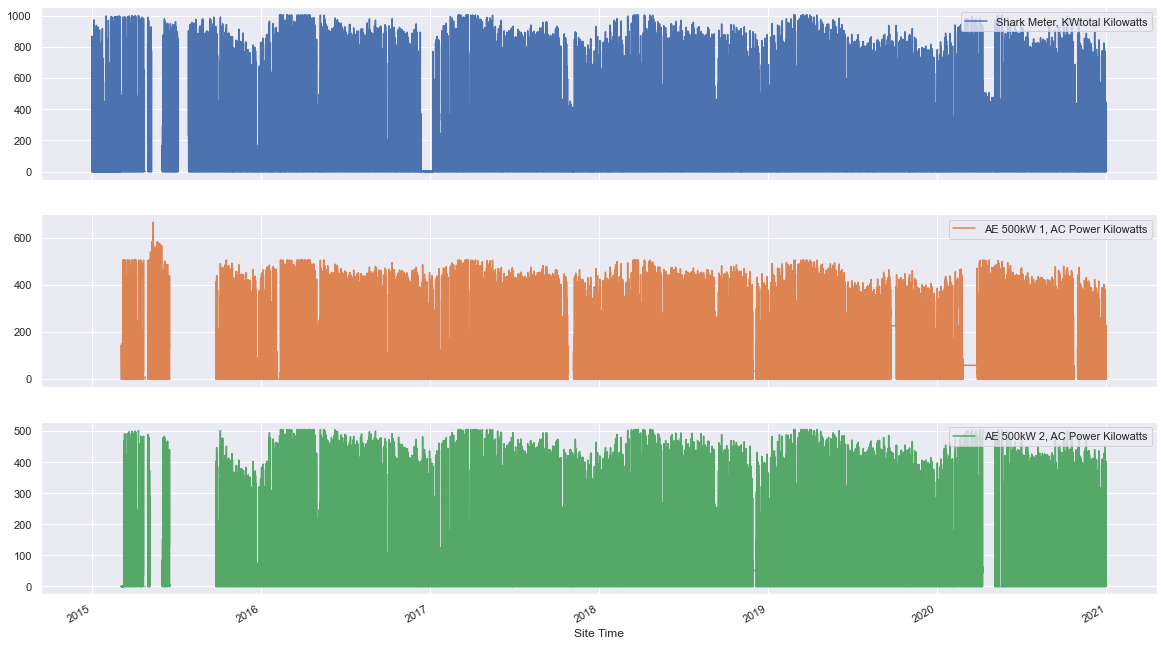

In [8]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']]\
        .plot(subplots=True, layout=(3,1), figsize=(20,12));

We've got so much missing data before late 2015, let's just drop the data before then.  

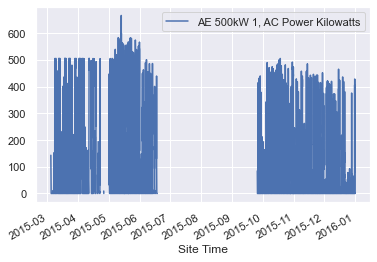

In [9]:
df[['AE 500kW 1, AC Power Kilowatts']].loc['2015'].plot();

So let's get rid of the data prior to Oct 2015.  

In [10]:
df = df.loc['2015-10':]

Now let's plot it again

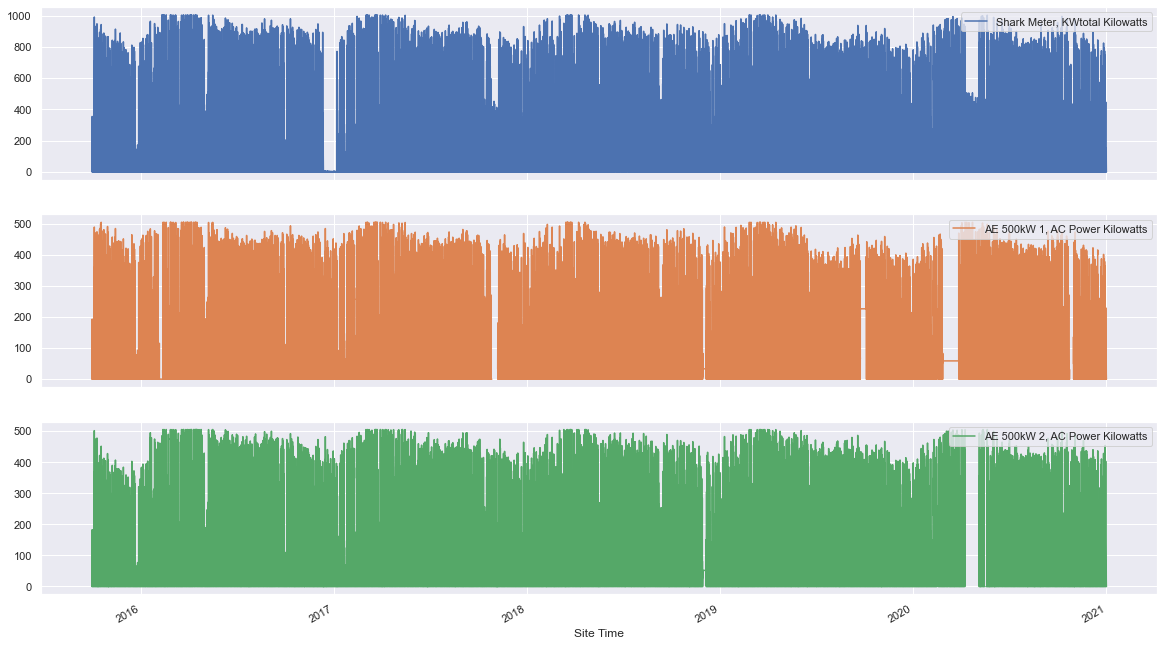

In [11]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']]\
        .plot(subplots=True, layout=(3,1), figsize=(20,12));

Let's look at the big hole in the meter in late 2016.

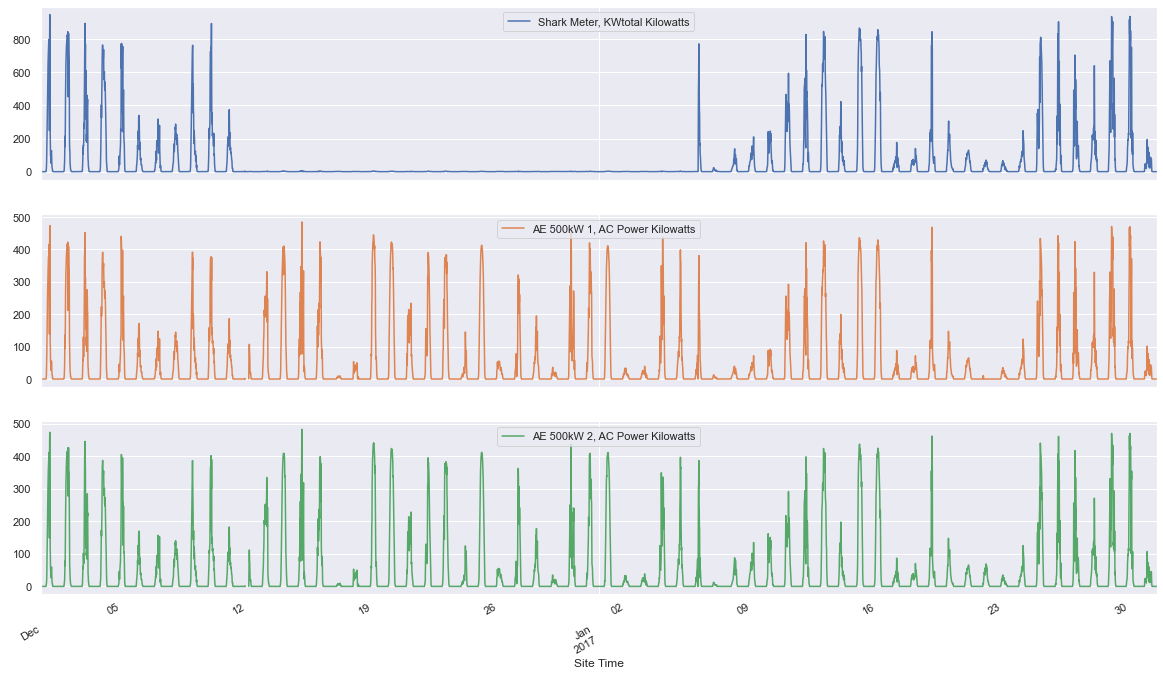

In [12]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].loc['2016-12':'2017-01'].plot(subplots=True, layout=(3,1),figsize=(20,12));

So we see that in this case, we don't have nulls, but we certainly can consider this missing data (a reporting problem) since the two inverters are producing data at this time.  For this case, we can fill the data with the sum of the two invertes.  

In [13]:
df['Shark Meter, KWtotal Kilowatts'].loc['2016-12-12':'2017-01-05'] = df.loc['2016-12-12':'2017-01-05'].apply(lambda x: x['AE 500kW 1, AC Power Kilowatts'] + x['AE 500kW 2, AC Power Kilowatts'], axis=1)

Now let's look at it again.

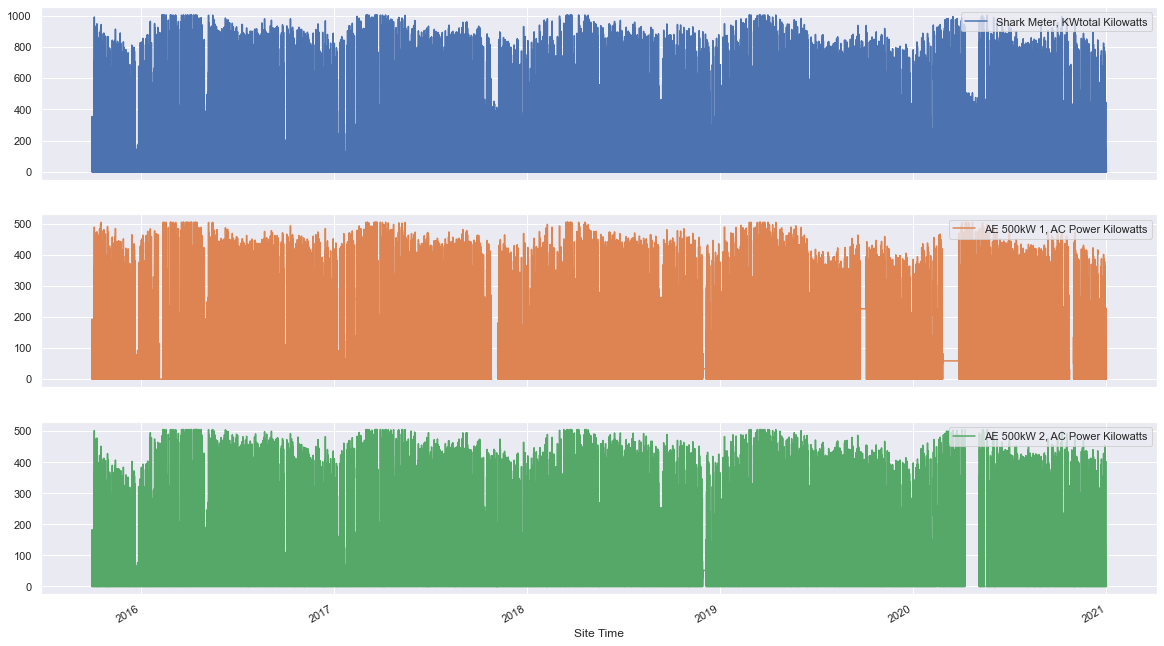

In [18]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']]\
        .plot(subplots=True, layout=(3,1), figsize=(20,12));

Now we've also got two sections where an inverter was out and we have low output.  Since we want to forecast overall trend let's fill these so that they don't impact our overall trend.  Note this is just for our general forecast.

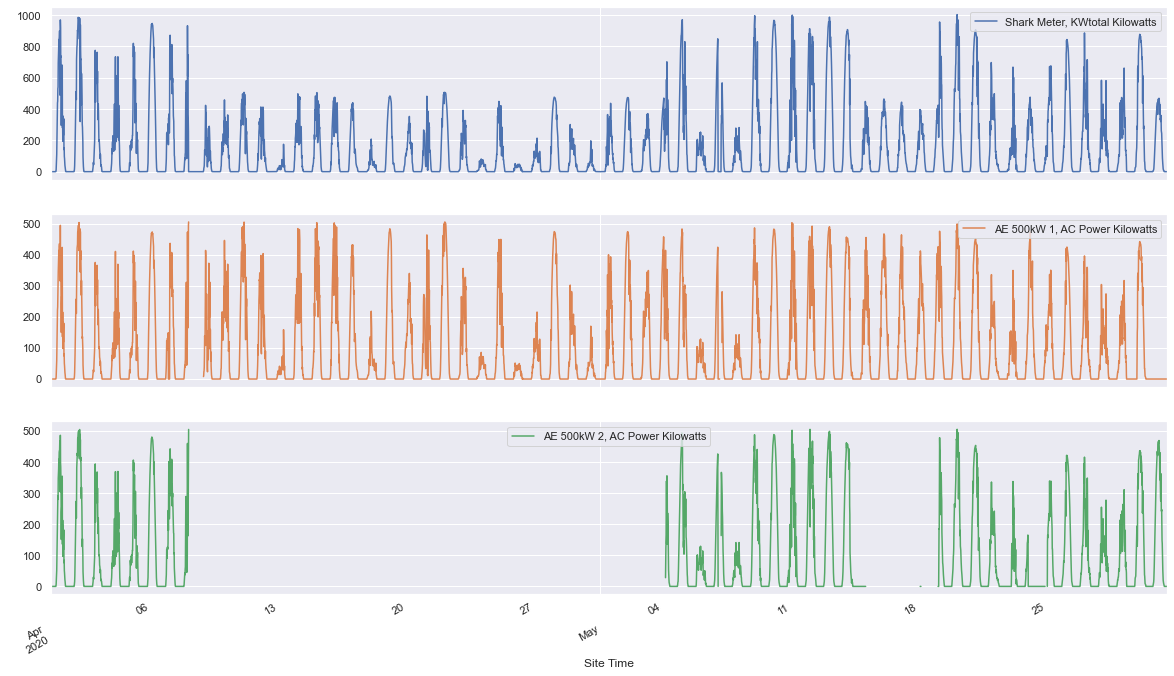

In [17]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].loc['2020-04':'2020-05'].plot(subplots=True, layout=(3,1),figsize=(20,12));

During this time let's replace the shark meter with twice the power of inverter 1.

In [18]:
df['Shark Meter, KWtotal Kilowatts'].loc['2020-04-06':'2020-05-20'] = df.loc['2020-04-06':'2020-05-20'].apply(lambda x: 2*x['AE 500kW 1, AC Power Kilowatts'], axis=1)

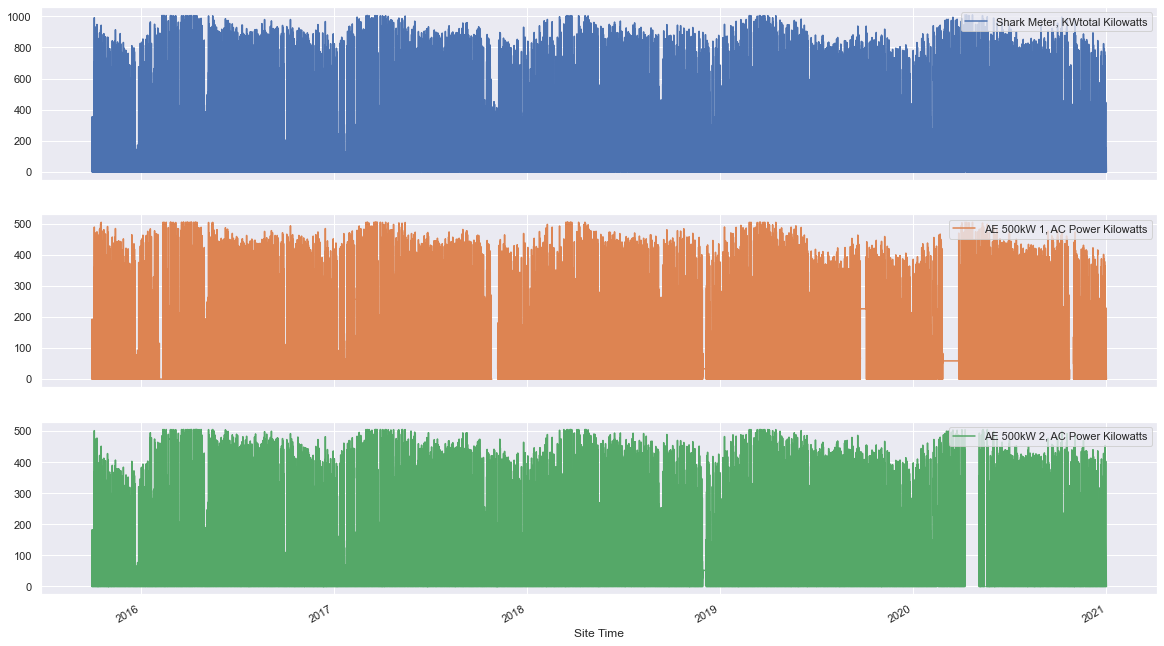

In [19]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']]\
        .plot(subplots=True, layout=(3,1), figsize=(20,12));

Let's do the same when inverter 1 was out in late 2017.  

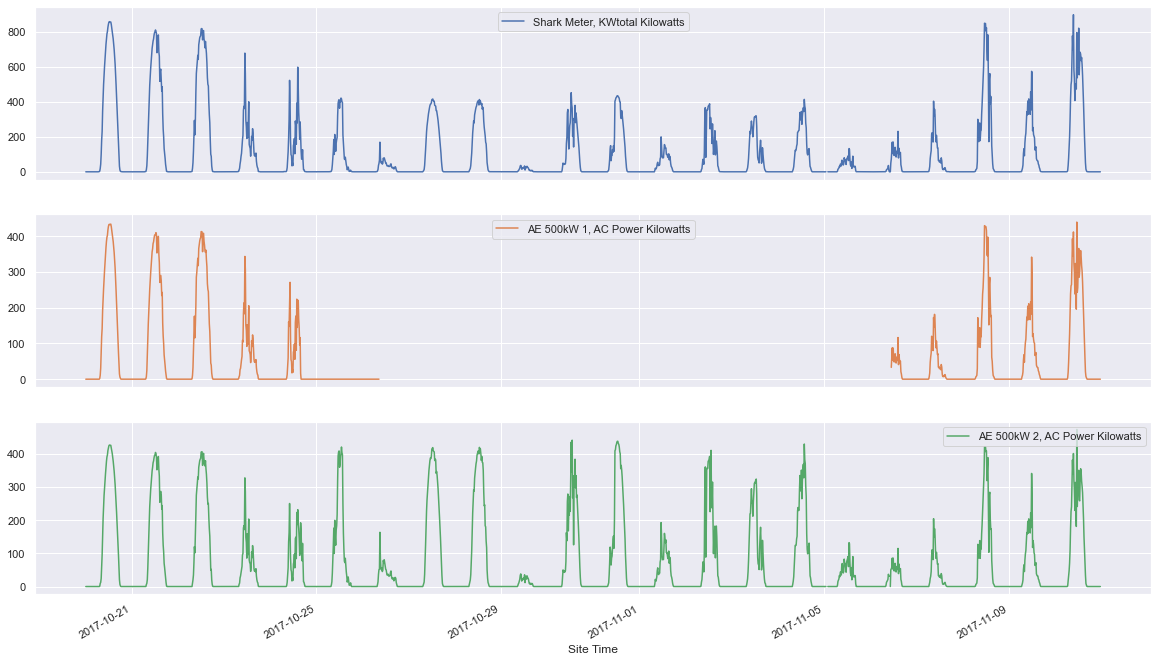

In [23]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].loc['2017-10-20':'2017-11-10'].plot(subplots=True, layout=(3,1),figsize=(20,12));

In [26]:
df['Shark Meter, KWtotal Kilowatts'].loc['2017-10-20':'2017-11-10'] = df.loc['2017-10-20':'2017-11-10'].apply(lambda x: 2*x['AE 500kW 2, AC Power Kilowatts'], axis=1)

That looks better and perhaps we can now use the shark meter data for forecasting.  Let's check for null values however.

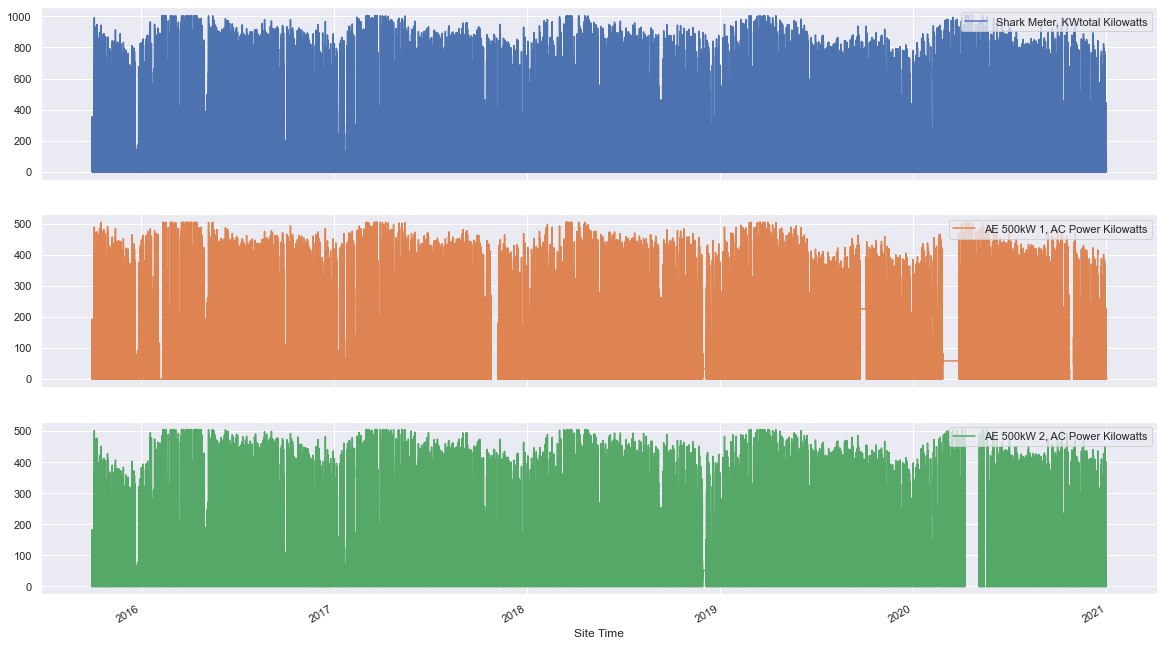

In [27]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']]\
        .plot(subplots=True, layout=(3,1), figsize=(20,12));

In [28]:
df['Shark Meter, KWtotal Kilowatts'].isnull().sum()

140

Not alot, so let's also fill these with 0. 

In [29]:
df['Shark Meter, KWtotal Kilowatts'].fillna(0, inplace=True)

Let's look at another instance, in late 2018, when it appears that one of the inverters was not functioning. 

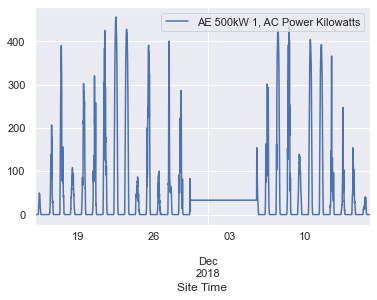

In [30]:
df[['AE 500kW 1, AC Power Kilowatts']].loc['2018-11-15':'2018-12-15'].plot();

In [31]:
df[['AE 500kW 1, AC Power Kilowatts']].loc['2018-11-15':'2018-12-15'].isnull().sum()

AE 500kW 1, AC Power Kilowatts    0
dtype: int64

So this is in instance when the inverter is not functioning correctly and is not producing power. We know this because the shark meter is producing half the normal power during this time. 
As a matter of fact, let's plot the difference between the shark meter and the sum of the two interverters.  

In [32]:
df['Power difference'] = df.apply(lambda x: x['Shark Meter, KWtotal Kilowatts'] \
                                   - x['AE 500kW 1, AC Power Kilowatts'] - x['AE 500kW 2, AC Power Kilowatts'], axis=1)

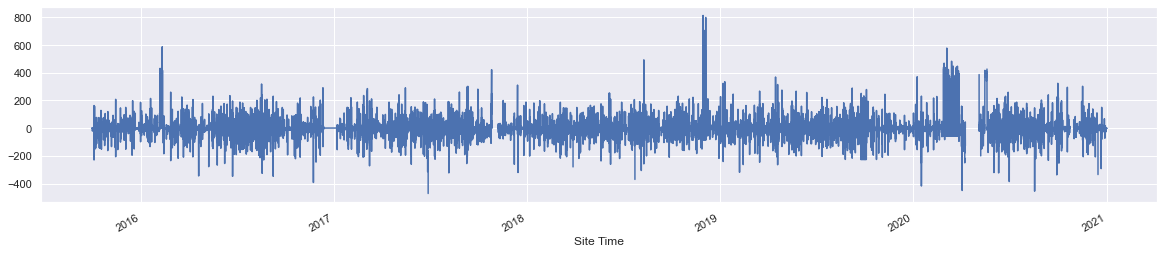

In [33]:
df['Power difference'].plot(figsize=(20,4))

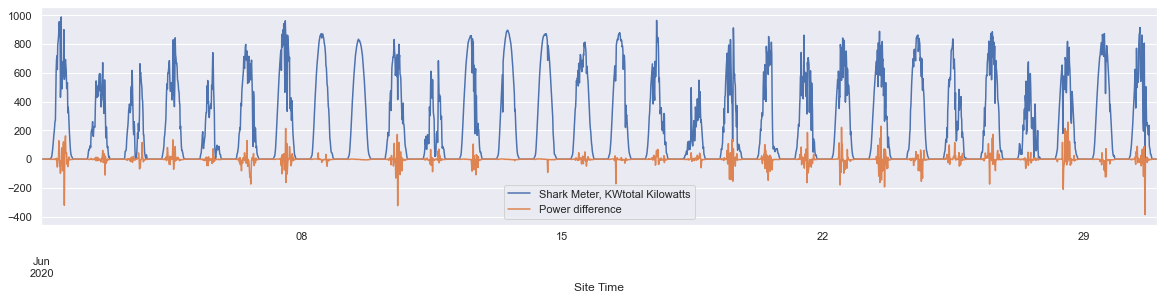

In [34]:
df[['Shark Meter, KWtotal Kilowatts','Power difference']].loc['2020-06'].plot(figsize=(20,4));

Ok, so the shark meter does not exactly equal the sum of the two inverters. Sometimes it's higher and sometimes it's lower.  But when the difference is large it means that there is a communication error between the inverters and the meter.  

Another thing we can look at is the difference between the two inverters.  They should be generating similar outputs. Let's look at the difference.  

In [35]:
df['Diff Power Inv1 and Inv2'] = df.apply(lambda x: x['AE 500kW 1, AC Power Kilowatts'] - x['AE 500kW 2, AC Power Kilowatts'], axis=1)

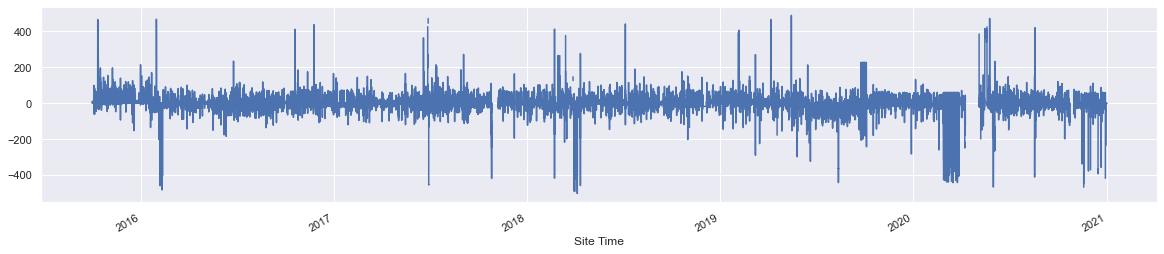

In [36]:
df['Diff Power Inv1 and Inv2'].plot(figsize=(20,4));

So that's interesting...all of those spikes are times when the inverters are not producing the same amount of power. What we might want to look at is times when the shark meter matches the sum of the two inverters but the inverters don't match each other.  That would be a sign that one of the inverters was not producing correctly.  

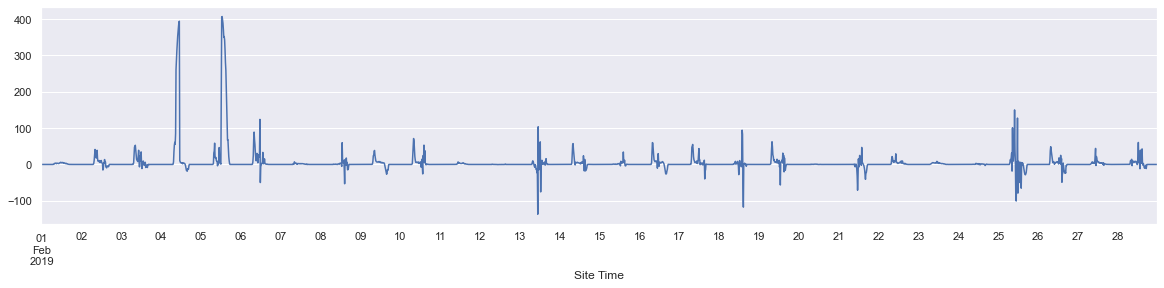

In [37]:
df['Diff Power Inv1 and Inv2'].loc['2019-02'].plot(figsize=(20,4));

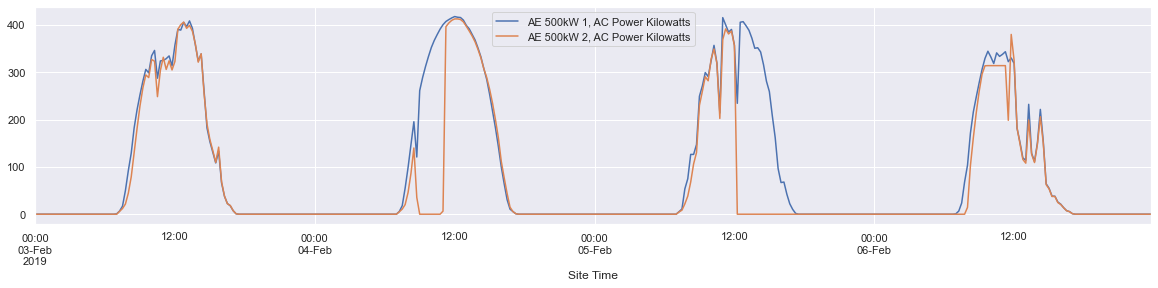

In [38]:
df[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].loc['2019-02-03':'2019-02-06'].plot(figsize=(20,4));

So presumably this is a problem with the second inverter.  We can see that over several days it has some strange behaviour.  

### Plot Irradiance

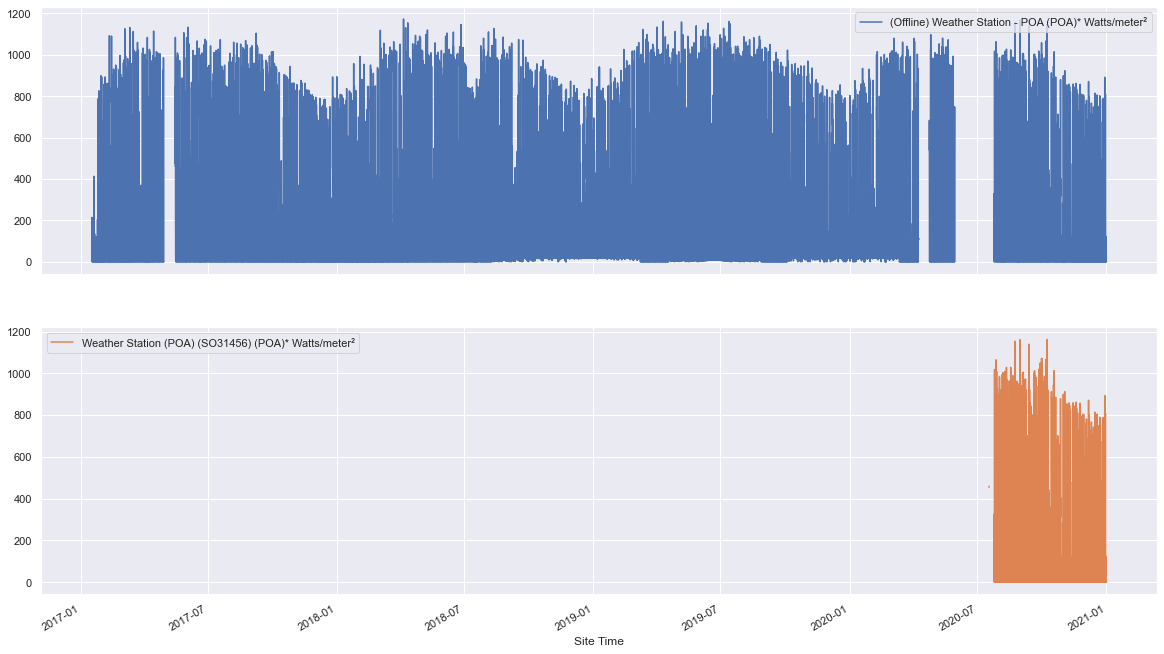

In [39]:
df[['(Offline) Weather Station - POA (POA)* Watts/meter²','Weather Station (POA) (SO31456) (POA)* Watts/meter²']]\
        .plot(subplots=True, layout=(2,1), figsize=(20,12));

We can see that they brough online a new device for measuring irradiance early in 2002, but we still have data from the old device and it's matching the new device, so let's just delete the column for the new device.

In [40]:
df.drop(columns=['Weather Station (POA) (SO31456) (POA)* Watts/meter²'], inplace=True)

### Plot temperature measurements

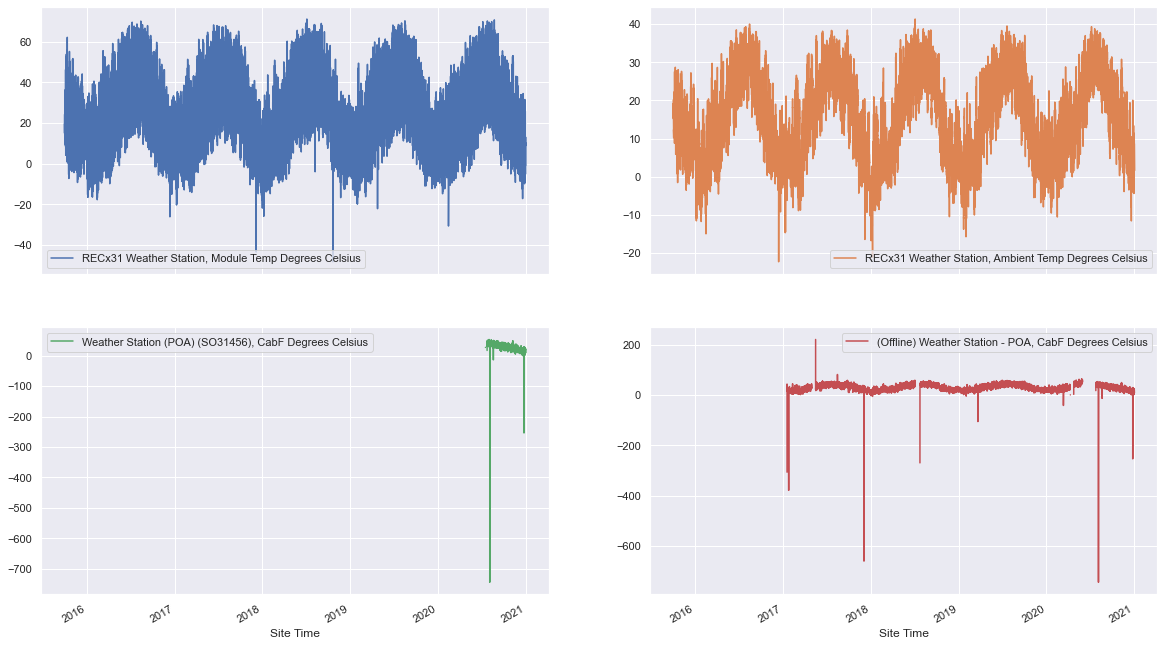

In [41]:
df[['RECx31 Weather Station, Module Temp Degrees Celsius','RECx31 Weather Station, Ambient Temp Degrees Celsius',\
       'Weather Station (POA) (SO31456), CabF Degrees Celsius','(Offline) Weather Station - POA, CabF Degrees Celsius']]\
        .plot(subplots=True, layout=(2,2), figsize=(20,12));

Again, the two CabF measurements have not been online the entire time, they have lots of outliers in the data, and we have the other two measurements so let's drop those.  

In [42]:
df.drop(columns=['Weather Station (POA) (SO31456), CabF Degrees Celsius','(Offline) Weather Station - POA, CabF Degrees Celsius'], inplace=True)

### Plot current and voltage measurements

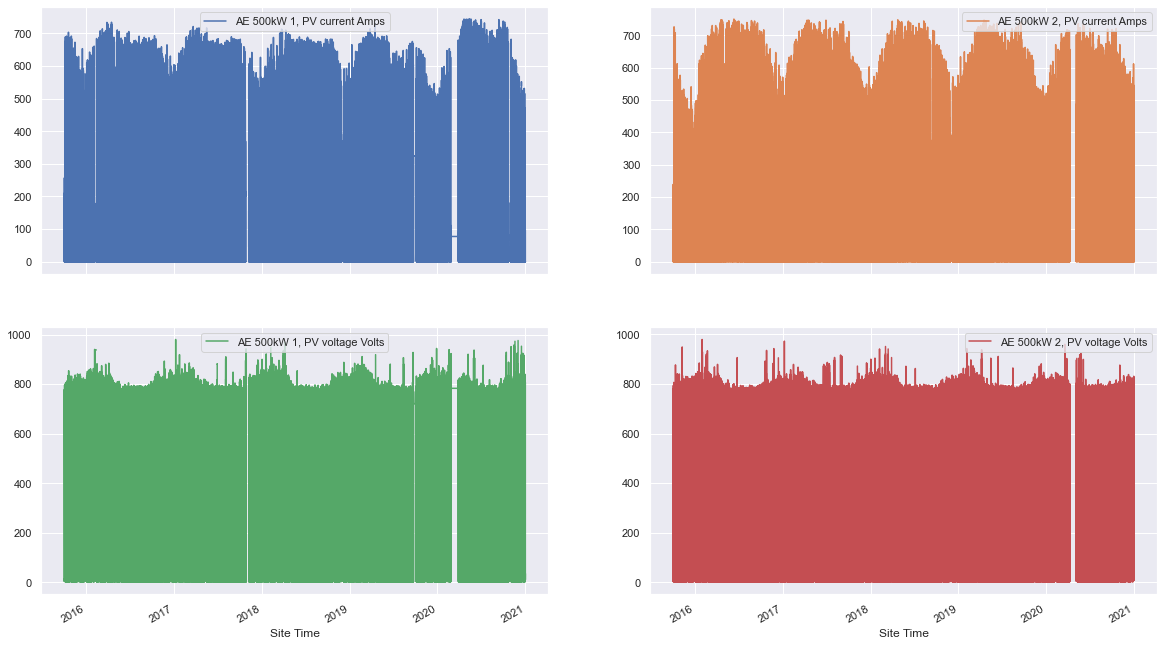

In [43]:
df[['AE 500kW 1, PV current Amps','AE 500kW 2, PV current Amps','AE 500kW 1, PV voltage Volts','AE 500kW 2, PV voltage Volts']]\
        .plot(subplots=True, layout=(2,2), figsize=(20,12));

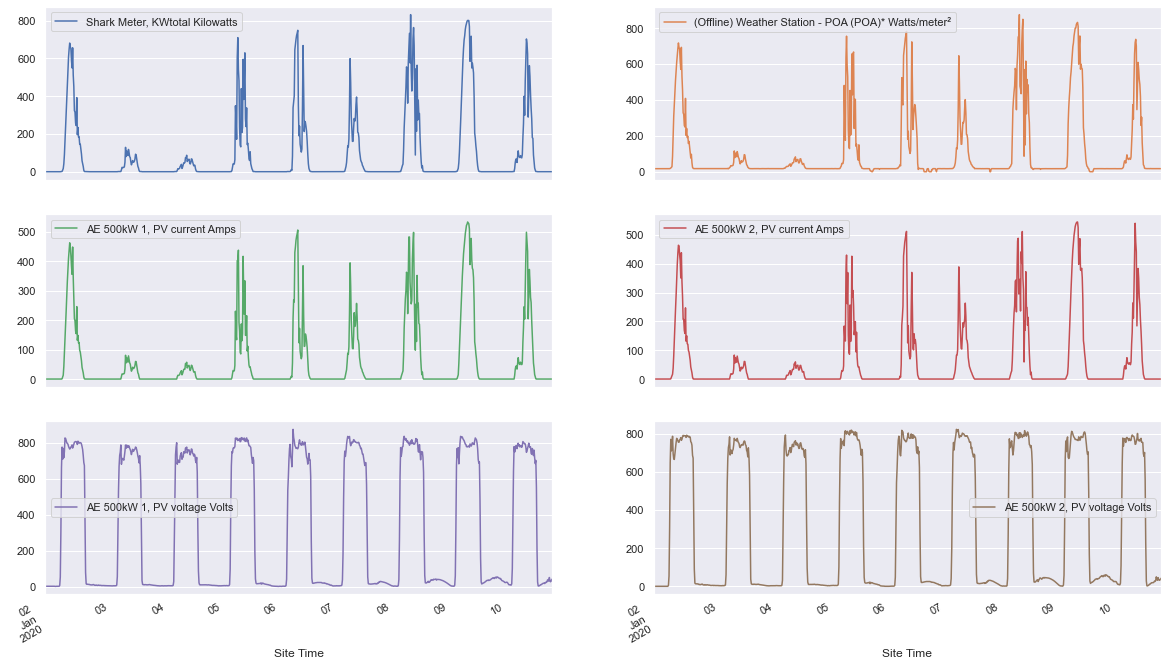

In [44]:
df[['Shark Meter, KWtotal Kilowatts','(Offline) Weather Station - POA (POA)* Watts/meter²','AE 500kW 1, PV current Amps','AE 500kW 2, PV current Amps','AE 500kW 1, PV voltage Volts','AE 500kW 2, PV voltage Volts']]\
        .loc['2020-01-02':'2020-01-10'].plot(subplots=True, layout=(3,2), figsize=(20,12));

So we can see that power tracks current which tracks irradiance.  

### Explore Output

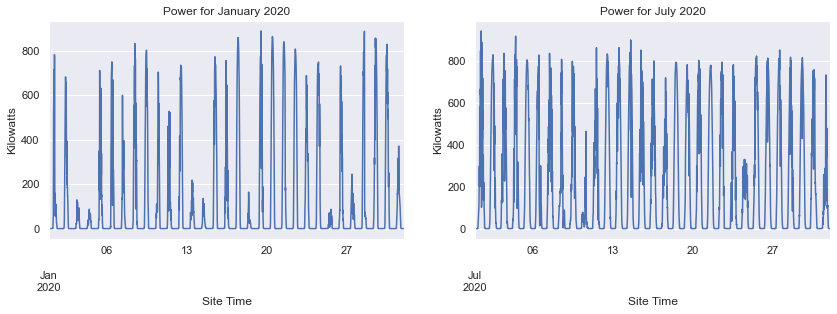

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
_ = plt.subplot(1,2,1)
df.loc['2020-01-01':'2020-01-31','Shark Meter, KWtotal Kilowatts'].plot()
_ = plt.title('Power for January 2020')
_ = plt.ylabel('Kilowatts')
_ = plt.subplot(1,2,2)
df.loc['2020-07-01':'2020-07-31','Shark Meter, KWtotal Kilowatts'].plot()
_ = plt.title('Power for July 2020')
_ = plt.ylabel('Kilowatts')

What we are seeing are power measurements, so we can see the seasonal variation in terms of the density of the July data as compared with the January data.  If we want to see the seasonality in terms of magnitude, we need to compute energy by integrating the time series data we have, or taking the 15-minute power measurements and summing them over the hour.  Let's look at just one week to see this more clearly.  

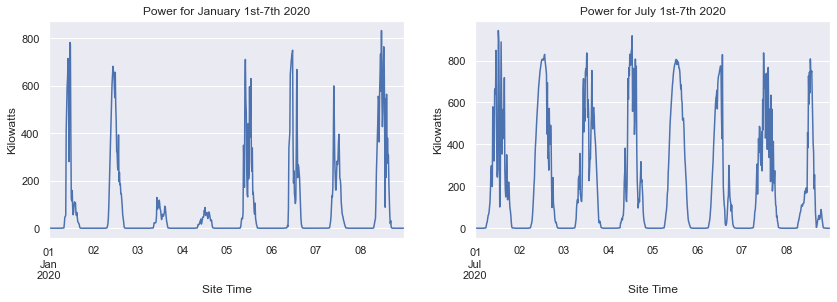

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
_ = plt.subplot(1,2,1)
df.loc['2020-01-01':'2020-01-08','Shark Meter, KWtotal Kilowatts'].plot()
_ = plt.title('Power for January 1st-7th 2020')
_ = plt.ylabel('Kilowatts')
_ = plt.subplot(1,2,2)
df.loc['2020-07-01':'2020-07-08','Shark Meter, KWtotal Kilowatts'].plot()
_ = plt.title('Power for July 1st-7th 2020')
_ = plt.ylabel('Kilowatts')

Now we can see clearly that in the summertime our maximum power values may not be higher, but the area under the curve certainly is.  So let's resample the data into kiloWattHours.  

I think we have duplicate entries in our timeseries index so we need to fix that.  

In [47]:
df.index.is_unique

False

A-ha!  That's the reason we are not able to infer the frequency of our index.  So let's groupby time, averaging the results.  

In [48]:
df = df.groupby(level=0).mean()

In [49]:
df = df.asfreq(freq='15T')

In [50]:
df.index

DatetimeIndex(['2015-10-01 00:00:00', '2015-10-01 00:15:00',
               '2015-10-01 00:30:00', '2015-10-01 00:45:00',
               '2015-10-01 01:00:00', '2015-10-01 01:15:00',
               '2015-10-01 01:30:00', '2015-10-01 01:45:00',
               '2015-10-01 02:00:00', '2015-10-01 02:15:00',
               ...
               '2020-12-31 21:30:00', '2020-12-31 21:45:00',
               '2020-12-31 22:00:00', '2020-12-31 22:15:00',
               '2020-12-31 22:30:00', '2020-12-31 22:45:00',
               '2020-12-31 23:00:00', '2020-12-31 23:15:00',
               '2020-12-31 23:30:00', '2020-12-31 23:45:00'],
              dtype='datetime64[ns]', name='Site Time', length=184224, freq='15T')

### Plot KWatt Hours

In [51]:
df_hourly = df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts', 'AE 500kW 2, AC Power Kilowatts']].resample('H').sum()*.25

In [52]:
df_hourly.columns = ['Shark Meter, KWH','AE 500kW 1, KWH','AE 500kW 2, KWH']

It's still hard to see the seasonal variation because the data is so noisy, so let's plot a rolling average of a day.  

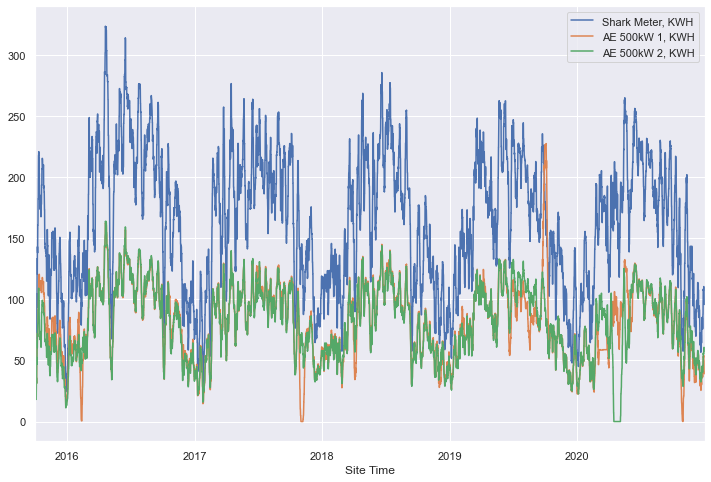

In [53]:
df_hourly.rolling(window='7D').mean().plot(figsize=(12,8));

Now we clearly see the seasonal varation in energy, and we see that the meter's output is the sum of the two inverters.  We can see where the second inverter had some sort of outage.  

We can see that the current on the inverters tracks the irradiance.  Let's add two columns, which is the ratio of current to irradiance and see what it looks like. 

In [54]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts',
       'Power difference', 'Diff Power Inv1 and Inv2'],
      dtype='object')

In [55]:
df['current1_over_irradiance'] = df['AE 500kW 1, PV current Amps']/ df['(Offline) Weather Station - POA (POA)* Watts/meter²']
df['current2_over_irradiance'] = df['AE 500kW 2, PV current Amps']/ df['(Offline) Weather Station - POA (POA)* Watts/meter²']

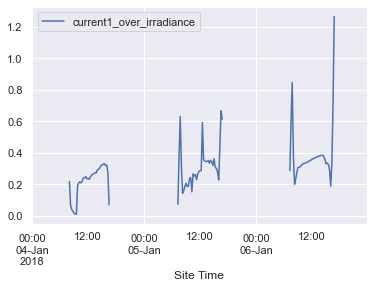

In [56]:
df[['current1_over_irradiance']].loc['2018-01-04':'2018-01-06'].plot();

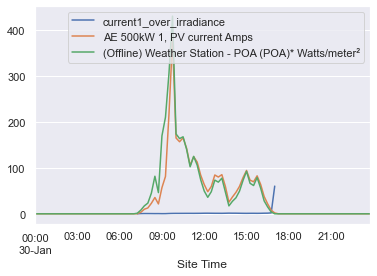

In [57]:
df[['current1_over_irradiance','AE 500kW 1, PV current Amps','(Offline) Weather Station - POA (POA)* Watts/meter²']].loc['2018-01-30'].plot();

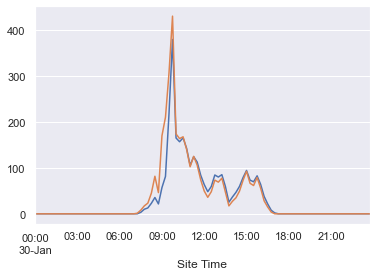

In [58]:
df[['AE 500kW 1, PV current Amps','(Offline) Weather Station - POA (POA)* Watts/meter²']].loc['2018-01-30'].plot(legend=False)

Let's try resampling to a daily average for current and irradiance and see if this shows anything

In [59]:
df_dailyavg = df[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts','(Offline) Weather Station - POA (POA)* Watts/meter²',\
                     'AE 500kW 1, PV current Amps','AE 500kW 2, PV current Amps']].resample('D').mean()

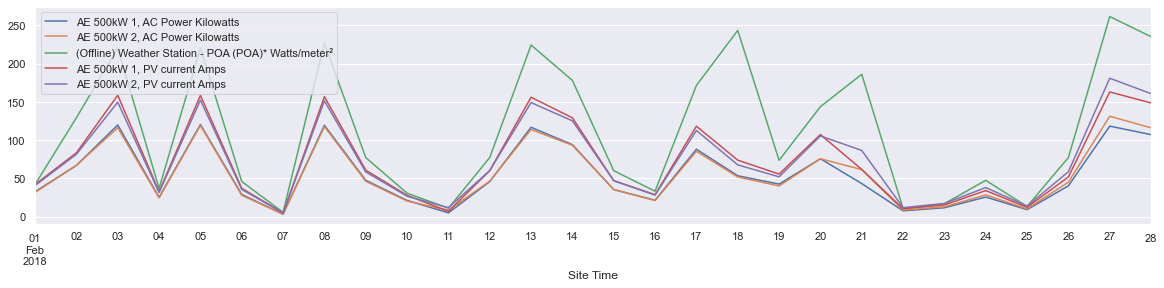

In [60]:
df_dailyavg.loc['2018-02'].plot(figsize=(20,4));

In [61]:
df_dailyavg.columns

Index(['AE 500kW 1, AC Power Kilowatts', 'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps'],
      dtype='object')

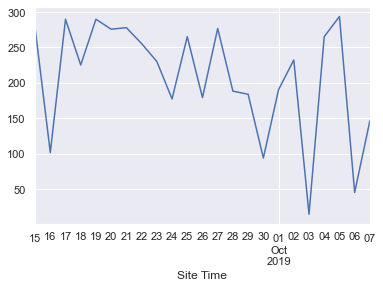

In [62]:
df_dailyavg['(Offline) Weather Station - POA (POA)* Watts/meter²'].loc['2019-09-15':'2019-10-07'].plot();

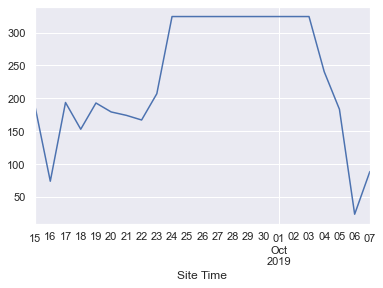

In [63]:
df_dailyavg['AE 500kW 1, PV current Amps'].loc['2019-09-15':'2019-10-07'].plot();

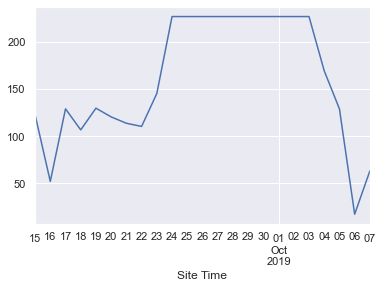

In [64]:
df_dailyavg['AE 500kW 1, AC Power Kilowatts'].loc['2019-09-15':'2019-10-07'].plot();

That's realy weird.  That must be a reporting issue, because the current and power stay high for several days even though the irradiance goes up and down.  So that's another oddity with the data.  

### Calculate Power = Voltage * Current

In [65]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts',
       'Power difference', 'Diff Power Inv1 and Inv2',
       'current1_over_irradiance', 'current2_over_irradiance'],
      dtype='object')

In [66]:
df['Voltage_x_Current_1'] = df.apply(lambda x: x['AE 500kW 1, PV current Amps'] * x['AE 500kW 1, PV voltage Volts'] * .001, axis=1)
df['Voltage_x_Current_2'] = df.apply(lambda x: x['AE 500kW 2, PV current Amps'] * x['AE 500kW 2, PV voltage Volts'] * .001, axis=1)

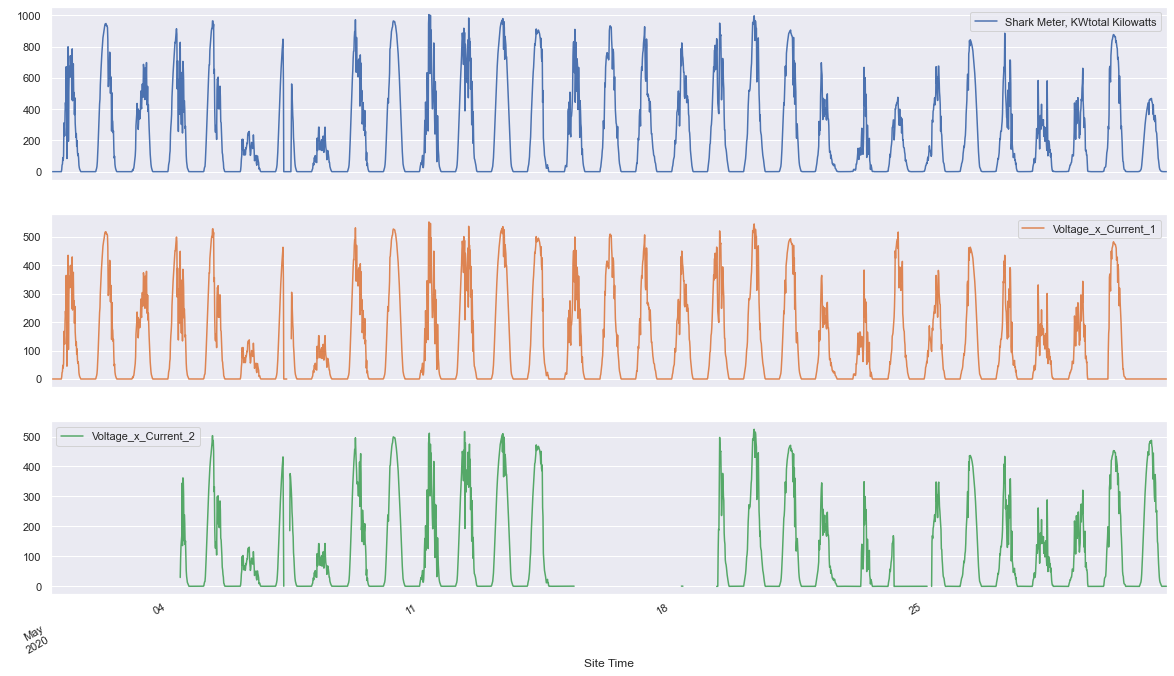

In [67]:
df[['Shark Meter, KWtotal Kilowatts','Voltage_x_Current_1','Voltage_x_Current_2']].loc['2020-05'].plot(subplots=True, layout=(3,1),figsize=(20,12));

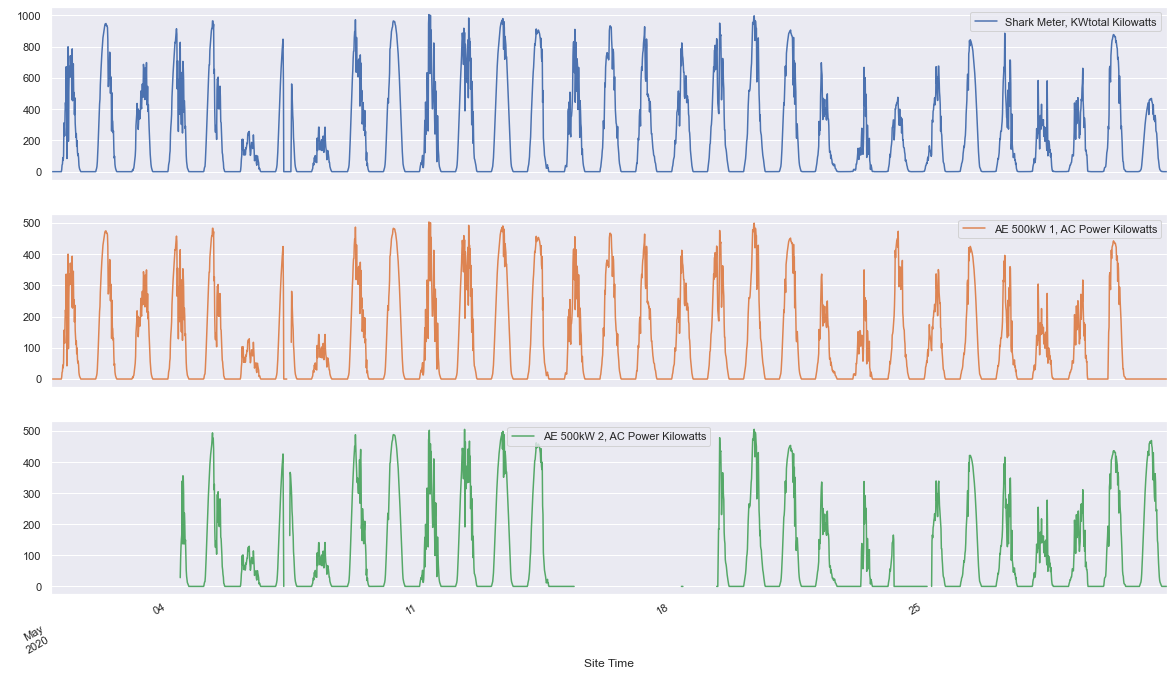

In [68]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].loc['2020-05'].plot(subplots=True, layout=(3,1),figsize=(20,12));

Let's try looking at calculated power vs reported power.

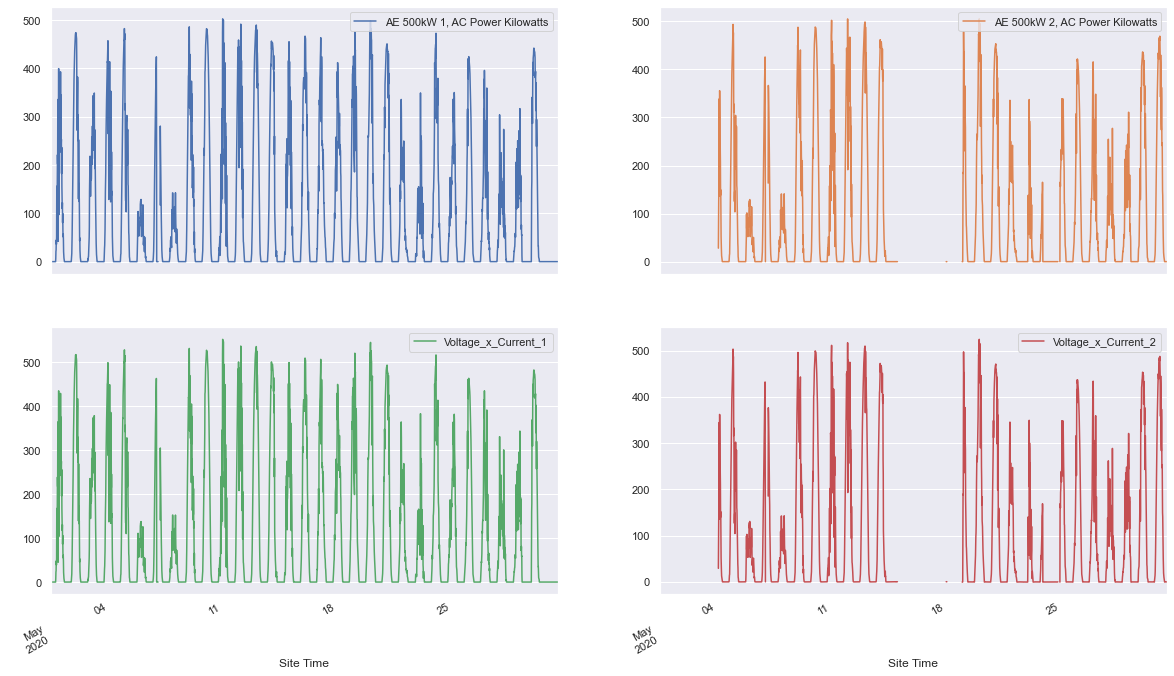

In [69]:
df[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts','Voltage_x_Current_1','Voltage_x_Current_2']].loc['2020-05'].plot(subplots=True, layout=(2,2),figsize=(20,12));

Ok, so that's a sanity check.  It appears our reported power is indeed equivalent to reported current * reported voltage.

### Conclusions so far

- power off the meter should be equivalent to the sum of the power off the two inverters but it is typically not.  Sometimes it's off by a little, sometimes a lot.  
- there is missing data (NaN's) and 0's.  Not always clear when a problem is indicated. 
- current tracks irradiance, and power tracks current.  There are outliers when this is not true.
- two inverters should be producing same current and same power but do not always track each other. Sometimes off by a little, sometimes a lot, which should indicate a problem.  



### Let's add Hour and Month to both our 15-minute and Hourly data

In [70]:
df_hourly.index

DatetimeIndex(['2015-10-01 00:00:00', '2015-10-01 01:00:00',
               '2015-10-01 02:00:00', '2015-10-01 03:00:00',
               '2015-10-01 04:00:00', '2015-10-01 05:00:00',
               '2015-10-01 06:00:00', '2015-10-01 07:00:00',
               '2015-10-01 08:00:00', '2015-10-01 09:00:00',
               ...
               '2020-12-31 14:00:00', '2020-12-31 15:00:00',
               '2020-12-31 16:00:00', '2020-12-31 17:00:00',
               '2020-12-31 18:00:00', '2020-12-31 19:00:00',
               '2020-12-31 20:00:00', '2020-12-31 21:00:00',
               '2020-12-31 22:00:00', '2020-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Site Time', length=46056, freq='H')

In [71]:
df['Month']=df.index.month
df['Hour']=df.index.hour
df['Year']=df.index.year
df_hourly['Month']=df_hourly.index.month
df_hourly['Hour']=df_hourly.index.hour
df_hourly['Year']=df_hourly.index.hour

In [72]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts',
       'Power difference', 'Diff Power Inv1 and Inv2',
       'current1_over_irradiance', 'current2_over_irradiance',
       'Voltage_x_Current_1', 'Voltage_x_Current_2', 'Month', 'Hour', 'Year'],
      dtype='object')

In [73]:
df_hourly.columns

Index(['Shark Meter, KWH', 'AE 500kW 1, KWH', 'AE 500kW 2, KWH', 'Month',
       'Hour', 'Year'],
      dtype='object')

In [74]:
# Let's output data for now so we can do some forecasting and see how that works
df[['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts']].to_csv('../data/interIm/filled_for_forecasting.csv')

In [75]:
df_hourly.to_csv('../data/interim/df_hourly.csv')